In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [87]:
class Agente:
    """ Agente general """
    def __init__(self, tipo, locacion=np.array([0,0])):
        self.tipo = tipo
        self.locacion = locacion
        self.siguiente_accion = None

    def distancia(self, otro):
        "Calcula la distancia euclídea entre este agente y otro."
        return np.linalg.norm(self.locacion - otro.locacion)  # Otra manera es usar np.sqrt(np.sum((a-b)**2))
    
    def vecinos(self, agentes):
        pass
    
    def actuar(self, agentes):
        self.locacion =  self.siguiente_accion
        
    def decidir(self, agentes):
        self.siguiente_accion = np.array([random.uniform(0, 1), random.uniform(0, 1)]) # Toma una nueva posición al azar
    
    def actualizar(self, agentes):
        self.decidir(agentes)
        self.actuar(agentes)

In [270]:
class habitante(Agente):
    """
    Aquí se encuentra el registro de los habitantes de Sugarscape.
    Su lugar de nacimiento y sus características individuales.
    """
    def __init__(self,id_h):     
        
        #Registro de los habitantes de Sugarscape
        self.id = id_h
        
        #Lugar de nacimiento de los habitantes
        self.x = np.random.randint(0,9)
        self.y = np.random.randint(0,9)
        
        #Atributos
        self.vision = 1
    
    def decision(self, ocupacion, Bienes):
        maximo = 0
        pos_x = 0
        pos_y = 0
        #print(self.x,self.y)
        #print("===================")
        for i in range(-1*self.vision,1*self.vision+1):
            for j in range(-1*self.vision,1*self.vision+1):
                #print(f'i:{i},j:{j},{Bienes[i][j]}')
                if (self.x + i >= 0 and self.y + j >= 0 and self.x + i <= 9 and self.y + j <= 9 and
                   Bienes[self.x+i][self.y+j].cantidad > maximo and ocupacion[self.x+i][self.y+j] == 0):
                    maximo = Bienes[self.x+i][self.y+j].cantidad
                    #print(f'max i:{i},j:{j},{Bienes[self.x+i][self.y+j]}')
                    pos_x = i
                    pos_y = j
        return pos_x, pos_y

    def actualizar(self, agentes, bienes, ocupacion):
        ocupacion_n = self.moverse(ocupacion, bienes) #Lo primero que hace es moverse
        bienes_n = self.comer(bienes) #Si se cumplen ciertas necesidades el habitante come
        return bienes_n, ocupacion_n

    def comer(self, bienes): #Si se cumplen ciertas necesidades el habitante come
        bienes[self.x][self.y].cantidad = 0 
        #print(f'i:{self.x},j:{self.y},{bienes[self.x][self.y]}')
        return bienes
                
    def moverse(self, ocupacion, Bienes):
        ocupacion[self.x][self.y] = 0
        i, j = self.decision(ocupacion, Bienes) #Se mueve en direccion al bien mas cercano
        self.x = self.x + i
        self.y = self.y + j
        #print(self.x,self.y)
        ocupacion[self.x][self.y] = 1
        return ocupacion

In [271]:
class bien(Agente):
    def __init__(self, tipo):
        #self.loc = np.array([random.randint(0, 51), random.randint(0, 51)]) #Posición al azar inicial
        self.tipo = tipo #Tipo 0 Especia, Tipo 1 Azucar
        alz = random.randint(0,3)
        if (alz == 0):
            self.cantidad = random.randint(0, 5)
        else:
            self.cantidad = 0
        
    def __str__(self):
        return str(self.cantidad)

In [272]:
class Mundo:
    def __init__(self, habitantes, bienes, steps, ancho = 51, alto = 51):
        self.habitantes = habitantes
        self.bienes = bienes
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.init_anim()
        
        print ("Creado el mundo")
        
    def init_anim(self):
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos, = self.ax.plot([], [], 'o', **plot_args)
       
       
    def dibujar(self, step):
        x_values_0, y_values_0 = [], []
        for agente in self.agentes:
            x, y = agente.locacion
            x_values_0.append(x)
            y_values_0.append(y)

        self.puntos.set_data(x_values_0, y_values_0)
        
        self.ax.set_title('Paso {}'.format(step))
        
        return self.puntos,
       
    def actualizar(self, step):   
        self.dibujar(step) # Dibuja el mundo
        for agente in self.agentes:
            self.bienes, self.ocupacion = agente.actualizar(self.agentes,self.bienes,self.ocupacion)
            
    
    def clean_screen(self):
        self.puntos.set_data([], [])
        return self.puntos,
    
    def simular(self):
        anim = animation.FuncAnimation(self.fig, self.actualizar, init_func=self.clean_screen, frames=self.steps, interval=1000, blit=False)
        return anim
    

In [273]:
class Sugarscape(Mundo):
    def __init__(self, c , ancho, alto, steps, habitantes):
        """
        c es la capacidad de azúcar de una celda, es decir, el valor
        máximo de unidades de azúcar que puede contener una celda.
        
        """
        
        self.ancho = ancho
        self.alto = alto
        self.steps = steps
        self.agentes = habitantes
        self.ocupacion = np.zeros([self.ancho, self.alto])
        for habitante in habitantes:
            self.ocupacion[habitante.x][habitante.y] = 1
        self.bienes = [[bien(i) for i in range(self.ancho)] for j in range(self.alto)]
        self.size = (self.ancho,self.alto)
        self.fig = plt.figure(figsize=(self.ancho, self.alto))
        self.ax = plt.axes(xlim=(0, self.ancho), ylim=(0, self.alto))
        
        #Propiedades de las parcelas de azúcar
        #Capacidad de azúcar por parcela/celda (aleatoria)
        self.capacidad = np.random.randint(0, c + 1, size = self.size)
        #Las unidades por parcela/celda
        self.level = np.random.randint(0, c + 1, size = self.size)
        #Para asegurar que la cantidad de unidades de azúcar por parcela
        #no excede la capacidad
        self.level = np.minimum.reduce([self.level,self.capacidad])
        #Habitantes y Azucares
        plot_args = {'markersize' : 8, 'alpha' : 0.6}
        self.puntos_H, = self.ax.plot([], [], 'o', markerfacecolor='orange', **plot_args)
        self.puntos_B, = self.ax.plot([], [], 'o', markerfacecolor='green', **plot_args)
    
    def clean_screen(self):
        self.puntos_H.set_data([], [])
        self.puntos_B.set_data([], [])
        return 
    
    def dibujar(self,step): #Se dibujan los habitantes en naranja y los bienes con verde
        
        self.clean_screen()
        
        x_values_H, y_values_H = [], []
        x_values_B, y_values_B = [], []
        
        for habitante in self.agentes:
            x = habitante.x
            y = habitante.y
            x_values_H.append(x)
            y_values_H.append(y)
        
        for i in range(self.ancho):
            for j in range(self.alto):
                if (self.bienes[i][j].cantidad != 0):
                    x_values_B.append(i)
                    y_values_B.append(j)

        self.puntos_H.set_data(x_values_H, y_values_H)
        self.puntos_B.set_data(x_values_B, y_values_B)
        
        self.ax.set_title('Paso {}'.format(step))

        return         

In [274]:
num_habitantes = 5

Habitantes = [habitante(i) for i in range(num_habitantes)]

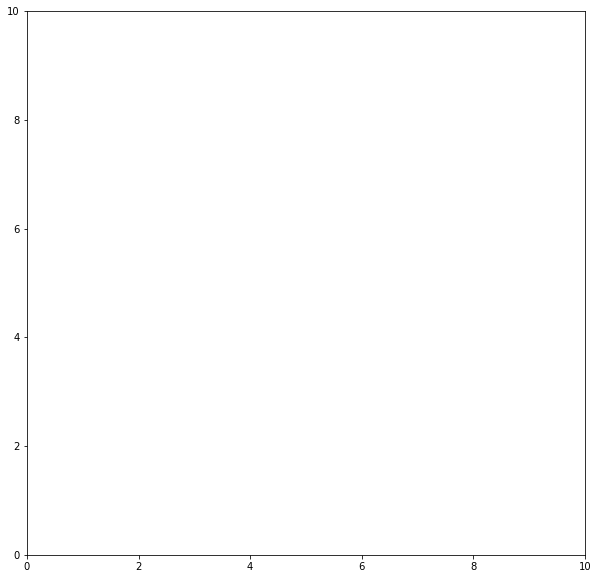

In [275]:
Mundo_azucarero = Sugarscape(c = 5, ancho = 10, alto = 10, steps = 10, habitantes = Habitantes)

simulacion = Mundo_azucarero.simular()

In [276]:
HTML(simulacion.to_html5_video())

In [149]:
for i in range(10):
    for j in range(10):
        print(f'i:{i},j:{j},{Mundo_azucarero.bienes[i][j]}')


i:0,j:0,3
i:0,j:1,0
i:0,j:2,0
i:0,j:3,1
i:0,j:4,0
i:0,j:5,3
i:0,j:6,0
i:0,j:7,0
i:0,j:8,0
i:0,j:9,0
i:1,j:0,0
i:1,j:1,3
i:1,j:2,3
i:1,j:3,1
i:1,j:4,0
i:1,j:5,0
i:1,j:6,0
i:1,j:7,5
i:1,j:8,0
i:1,j:9,0
i:2,j:0,2
i:2,j:1,5
i:2,j:2,1
i:2,j:3,3
i:2,j:4,0
i:2,j:5,3
i:2,j:6,4
i:2,j:7,1
i:2,j:8,0
i:2,j:9,0
i:3,j:0,0
i:3,j:1,0
i:3,j:2,0
i:3,j:3,4
i:3,j:4,0
i:3,j:5,0
i:3,j:6,0
i:3,j:7,0
i:3,j:8,0
i:3,j:9,0
i:4,j:0,3
i:4,j:1,3
i:4,j:2,0
i:4,j:3,0
i:4,j:4,0
i:4,j:5,4
i:4,j:6,0
i:4,j:7,2
i:4,j:8,0
i:4,j:9,0
i:5,j:0,0
i:5,j:1,3
i:5,j:2,1
i:5,j:3,5
i:5,j:4,1
i:5,j:5,0
i:5,j:6,0
i:5,j:7,0
i:5,j:8,2
i:5,j:9,0
i:6,j:0,4
i:6,j:1,3
i:6,j:2,0
i:6,j:3,0
i:6,j:4,2
i:6,j:5,2
i:6,j:6,0
i:6,j:7,3
i:6,j:8,1
i:6,j:9,3
i:7,j:0,0
i:7,j:1,0
i:7,j:2,1
i:7,j:3,0
i:7,j:4,0
i:7,j:5,1
i:7,j:6,2
i:7,j:7,0
i:7,j:8,0
i:7,j:9,0
i:8,j:0,0
i:8,j:1,5
i:8,j:2,0
i:8,j:3,0
i:8,j:4,0
i:8,j:5,0
i:8,j:6,0
i:8,j:7,0
i:8,j:8,0
i:8,j:9,0
i:9,j:0,3
i:9,j:1,0
i:9,j:2,0
i:9,j:3,5
i:9,j:4,0
i:9,j:5,0
i:9,j:6,0
i:9,j:7,0
i:9,j:8,0
i:9,j:9,0


In [ ]:
print(Mundo_azucarero.bienes[i][j])

In [146]:
print(Mundo_azucarero.bienes[0][8])

0


# Poblacion

In [ ]:
for t in range(duracion):
    mercado_ideal.evolucionar(t)

tiempo_simulacion = np.linspace(0,1, duracion)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,0], label="Demanda")
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,1], label="Oferta")
plt.xlabel("tiempo")
plt.legend(loc="best")

# Cantidad de bienes

In [ ]:
for t in range(duracion):
    mercado_ideal.evolucionar(t)

tiempo_simulacion = np.linspace(0,1, duracion)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,0], label="Demanda")
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,1], label="Oferta")
plt.xlabel("tiempo")
plt.legend(loc="best")

# Curva de Lorenz 

In [ ]:
for t in range(duracion):
    mercado_ideal.evolucionar(t)

tiempo_simulacion = np.linspace(0,1, duracion)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,0], label="Demanda")
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,1], label="Oferta")
plt.xlabel("tiempo")
plt.legend(loc="best")

# Coeficiente de Gini

In [ ]:
for t in range(duracion):
    mercado_ideal.evolucionar(t)

tiempo_simulacion = np.linspace(0,1, duracion)

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,0], label="Demanda")
plt.plot(tiempo_simulacion, mercado_ideal.demanda_oferta[:,1], label="Oferta")
plt.xlabel("tiempo")
plt.legend(loc="best")

- ¿Qué pasa si la variable `tribu` afecta el comercio y el sexo? ¿Cómo lo simularías y por qué?

Si se agregara elementos a tribu dentro de agente que afectara el comercio entonces se podria simular mejor manera una verdadera sociedad. Por ejemplo, puede ser que diferentes tribus le den mas valor a diferentes bienes y asi el comercio entre ellos sea mas facil, o, agregar ciertos elementos a la tribus de que tan bien se llevan con las otras tribus, si se llevan bien, facilitar el comercio e incluso poder "ayudar" a otras tribus. En terminos de el sexo consideramos que no seria la mejor idea que una tribu tenga influenza dentro de el sexo de los habitantes, primero que nada porque no sabriamos como funcionaria, despues porque asi no funciona en la vida real. Lo unico que podemos pensar es si una tribu por sus creencias acepta menos a un genero entonces podria haber algo ahi pero no le vemos mucho uso en esta simulacion. Si se habla de reproduccion sexual entonces podria estar mas interesante ya que se podrian crear tribus que solo tengan sexo para mantener la poblacion constante, mientras otras tribus podrian ser mas liberales sobre su decision de reproducirse, asi aumentando la poblacion, requierendo de mas bienes para sobrevivir pero con mas manos para recolectar esos bienes

- ¿Cómo simularías **guerra primitiva**?

Una guerra primitiva se simularia de mejor manera si se hiciera agregando a los elementos de tribu. A pesar de que se podria hacer entre solo habitantes cuando un habitante no tiene bienes y tiene hambre podria empezar a buscar a otro habiante para robarle sus bienes. Pero en terminos de guerra la mejor forma seria si se le agregara un elemento a cada tribu de "storage" en donde principalmente si una tribu tiene muchos bienes y otra se esta mueriendo de hambre, la tribu que se esta muriendo de hambre vaya a hacer la guerra para tratar de conseguir esos bienes. Para esto tambien se tendria que agregar otros elementos principalmente en los agentes, cosas como fuerza y salud. Si se buscara ir aun mas haya se agregaria a la simulacion cosas como armas o incluso estrategias

- ¿Cómo simularías **enfermedad**?

Para simular una enferemedad en este proyecto tendria que primero haber algo dentro de el mundo que 
despues de cada paso o despues de cada cierta cantidad de pasos a uno de los habitantes le de una enferemdad.
Despues de eso se tendra que determinar los efectos de la enfermedad asi como que tan contagiosa es y su mortalidad. Puede ser que la enfermedad solo afecte que tanto se mueve las personas, o que baja mas rapido su atributo hambre, puede que para contagiarse otro habitante tiene que pasar muy cerca de el y tener una pequeña chance, o que cubra un radio mucho mas grande y que sea mucho mas probable que le de. La mortalidad podra variar entre que solo tenga los efectos de la enfermedad por ciertos pasos o que vayan empeorando hasta incluso la muerte.

- ¿Quieres incluir **genética**? 
    - Define una cadena binaria (i.e. de ceros y unos) en los que se estén codificadas el sexo, capacidad de almacenar azúcar, metabolismo, rango de visión.
    - Cuando los agentes se reproduzcan sexualmente, realiza un [`crossover`](http://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)) para determinar los atributos de los agentes de la siguiente generación.

Incluir genetica dentro de la simulacion podria tener mucho valor, ya que podria incluir elementos que tambien simulen "survival of the fittest". Dentro de la simulacion se podrian incluir varios atributos que determinen la eficiencia en la que realizan acciones: velocidad, necesidad de comer, habilidad reproductora, habilidad de negociacion, fuerza (para elementos de guerra), etc. Y despues de cierta cantidad de pasos, se podria checar cuales son los genes que siguen vivos en los habitantes, para poder ver cuales son los genes que sobrevivieron

- Agrega una asimetría de sexo, esto lo puedes modelar con un `offspring_cost` que sea mayor para uno de los sexos. Entonces antes de reproducirse sexualmente, hay una decisión por parte de los agentes.

Si se agregara una asimetria de sexo a la genetica podria agregar un elemento a la simulacion, suponiendo que los habitantes saben sobre esta asimetria de sexo, que podria variar entre habitante y habitante, se podria crear un algortimo de decision en donde dependiendo de tanto su propia genetica como la de la posible pareja se decida si tener otro habitante tomando en cuenta las posibilidades de mejor o peores atributos para el offspring

# Cosas para mejorar en el futuro

.

- Bienes crecen mas frecuentemente en diferentes locaciones

- Las tribus tienen "hogares" locaciones a las cuales regresan

- Diferentes tipos de enfermedades

- Hacer de el proceso de reproducion que empiecen sin poder alimentarse los bebes por lo que tienen que alimentarlo los padres

- Crear parejas que compartan bienes y se queden juntos

- Agregar otro tipo de actividad (Pesca, cultivacion)

- Agregar necesidades (descansar, tomar agua)

- Agregar mas bienes necesarios para otras cosas (arboles para casas, rocas para herramientas, cuero para ropa)

- Agregar animales

- Agregar mas elementos a la genetica (habilidad de construir, habilidad de pescar, agresividad)